In [1]:
import math
import time
import scipy
import QuantLib
import xlsxwriter
import numpy as np
import pandas as pd
import xlwings as xw
import QuantLib as ql
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

## Implementación Computacional

Primero que todo a grandes rasgos nuestra implementación consistió en crear las clases HW y JY las cuales contienen todos los método necesarios para realizar la simulación y para realizar los gráficos que estimemos convenientes. De aquí en más iremos presentando a medida que se van presentando resultados.

In [2]:
tiempo_inicial_todo = time.time()

In [3]:
def data_df_to_curve(data_df):
    dates = [ql.Date(i.day, i.month, i.year) for i in list(data_df.index)]
    largo_yf = (dates[-1] - dates[0])/360
    dfs = list(data_df["DF"])
    dayCounter = ql.Actual360()
    curve = ql.DiscountCurve(dates, dfs, dayCounter)
    return curve, largo_yf

In [4]:
class HullWhite:
    
    def __init__(self, a, sigma, curve, r0, nro_simu):
        self.sigma = sigma
        self.a = a
        self.curve = curve[0]
        self.T = curve[1]
        self.r0 = r0
        self.nro_simu = nro_simu
        self.dt = 1/12
        self.nro_periodos = int(self.T/self.dt) + 1
        self.epsilon = self.dt
        self.t_lim = (self.nro_periodos-1)*self.dt
        self.media_movil = 10
        self.tolerancia = 10**(-4)
        
    def funcion_M(self, T):
        if T >= self.t_lim:
            valor = -(math.log(self.curve.discount(T)) - math.log(self.curve.discount(T-self.epsilon)))/self.epsilon
        else:
            valor = -(math.log(self.curve.discount(T + self.epsilon)) - math.log(self.curve.discount(T)))/self.epsilon
        return valor
    
    def derivada_funcion_M(self, T):
        if T >= self.t_lim:
            valor = (self.funcion_M(T) - self.funcion_M(T-self.epsilon))/self.epsilon
        else:
            valor = (self.funcion_M(T+self.epsilon) - self.funcion_M(T))/self.epsilon
        return valor
    
    def theta_t(self, t):
        valor_1 = self.derivada_funcion_M(t) + self.a*self.funcion_M(t) 
        valor_2 = ((self.sigma**2)/(2*self.a))*(1-math.exp(-2*self.a*t))
        valor = valor_1 + valor_2
        return valor
    
    def creacion_theta(self):
        self.tiempos = []
        for i in range(self.nro_periodos):
            self.tiempos.append(i*self.dt)
        self.theta = []
        for t in self.tiempos:
            self.theta.append(self.theta_t(t))
    
    def graficar_theta(self):
        fig, ax = plt.subplots(figsize=(17,10))
        ax.plot(self.tiempos, self.theta, lw = 0.8, alpha = 0.6, color = "red")
    
    def B(self, t, T):
        valor = (1/self.a)*(1-math.exp(-self.a*(T-t)))
        return valor
    
    def A(self, t, T):
        fraccion = self.curve.discount(T)/self.curve.discount(t)
        exponente = self.B(t, T)*self.funcion_M(t) - ((self.sigma**2)/(4*self.a))*(1-math.exp(-2*self.a*t))*((self.B(t,T))**2)
        valor = fraccion*math.exp(exponente)
        return valor
    
    def crear_matriz_A_B(self):
        self.matriz_A = []
        self.matriz_B = []
        for i in range(self.nro_periodos):
            fila_A = []
            fila_B = []
            for j in range(self.nro_periodos):
                if i<=j:
                    t = i*self.dt
                    T = j*self.dt
                    fila_A.append(self.A(t, T))
                    fila_B.append(self.B(t, T))
                else:
                    fila_A.append(0)
                    fila_B.append(0)
            self.matriz_A.append(fila_A)
            self.matriz_B.append(fila_B)
    
    def creating_path(self):
        dW = []
        for k in range(self.nro_periodos):
            dW.append(np.random.normal(0, 1, 1))
        r = [self.r0]
        for i in range(self.nro_periodos):
            r.append(r[i] + (self.theta[i] - self.a*r[i])*self.dt + self.sigma*dW[i]*math.sqrt(self.dt))
        return r
    
    def creacion_simulacion(self):
        self.path = []
        for i in range(self.nro_simu):
            self.path.append(self.creating_path())
        self.max_path = []
        self.min_path = []
        self.p_75_path = []
        self.p_50_path = []
        self.p_25_path = []
        for i in range(self.nro_periodos + 1):
            lista = []
            for j in range(self.nro_simu):
                lista.append(self.path[j][i])
            self.max_path.append(max(lista))
            self.min_path.append(min(lista))
            self.p_75_path.append(np.percentile(lista, 75))
            self.p_50_path.append(np.percentile(lista, 50))
            self.p_25_path.append(np.percentile(lista, 25))
    
    def graficar_simulaciones(self):
        fig, ax = plt.subplots(figsize=(17,10))
        self.nuevos_tiempos = []
        for i in range(len(self.path[0])):
            self.nuevos_tiempos.append(i*self.dt)
        for k in self.path:
            ax.plot(self.nuevos_tiempos, k, lw = 0.8, alpha = 0.6)
    
    def graficar_percentiles_simu(self):
        fig, ax = plt.subplots(figsize=(17,10))
        ax.plot(self.nuevos_tiempos, self.max_path, lw = 0.8, alpha = 0.6, color = "green")
        ax.plot(self.nuevos_tiempos, self.min_path, lw = 0.8, alpha = 0.6, color = "green")
        ax.plot(self.nuevos_tiempos, self.p_25_path, lw = 0.8, alpha = 0.6, color = "red")
        ax.plot(self.nuevos_tiempos, self.p_75_path, lw = 0.8, alpha = 0.6, color = "red")
        ax.plot(self.nuevos_tiempos, self.p_50_path, lw = 0.8, alpha = 0.6, color = "blue")
    
    def curvas_descuento(self):
        self.curvas_descuento_todas = []
        for i in range(self.nro_simu):
            curvas_sim = []
            for j in range(self.nro_periodos):
                curva = []
                for k in range(j, self.nro_periodos):
                    curva.append(self.matriz_A[j][k]*math.exp(-self.matriz_B[j][k]*self.path[i][j]))
                curvas_sim.append(curva)
            self.curvas_descuento_todas.append(curvas_sim)
            
    def curva_descuento_media(self):
        self.curva_media = []
        for i in range(self.nro_periodos):
            curva = []
            for j in range(i, self.nro_periodos):
                curva.append(self.matriz_A[i][j]*math.exp(-self.matriz_B[i][j]*self.p_50_path[i]))
            self.curva_media.append(curva)
    
    def graficar_curvas_descuento_media(self):
        fig, ax = plt.subplots(figsize=(17,10))
        for i in range(len(self.curva_media)):
            ax.plot(self.tiempos[i:len(self.nuevos_tiempos)], self.curva_media[i], lw = 0.8, alpha = 0.6)
    
    def curva_descuentos_aproximada(self):
        curvas_totales = []
        for i in range(len(self.path)):
            nueva_curva = []
            suma = 0
            for j in range(len(self.path[0])):
                suma = suma + self.path[i][j]
                nueva_curva.append(math.exp(-suma*self.dt))
            curvas_totales.append(nueva_curva)
        self.curva_descuentos_aproximada = []
        for t in range(len(curvas_totales[0])):
            lista = []
            for p in range(len(curvas_totales)):
                lista.append(curvas_totales[p][t])
            media = np.mean(lista)
            self.curva_descuentos_aproximada.append(media)
    
    def graficar_curvas_descuento_aproximada(self):
        fig, ax = plt.subplots(figsize=(17,10))
        grafico_1, = ax.plot(self.nuevos_tiempos, self.curva_descuentos_aproximada, lw = 0.8, alpha = 0.6, color = "red")
        grafico_2, = ax.plot(self.tiempos, self.curva_media[0], lw = 0.8, alpha = 0.6, color = "blue")
        self.curva_dada = []
        for t in self.tiempos:
            self.curva_dada.append(self.curve.discount(t))
        grafico_3, = ax.plot(self.tiempos, self.curva_dada, lw = 0.8, alpha = 0.6, color = "green")  
        grafico_1.set_label("Curva aproximada")
        grafico_2.set_label("Curva simulada")
        grafico_3.set_label("Curva dada")
        ax.legend()
        
    def calcular_error(self):
        error = 0
        for i in range(len(self.tiempos)):
            error = error + abs(self.curva_media[0][i] - self.curva_descuentos_aproximada[i])
        return error/len(self.tiempos)

In [5]:
def calibrar_HW(a, sigma, curve, r0, nro_simu, n_particiones):
    A = min(1, 100*sigma)
    da = A/n_particiones
    a = [da]
    errores = []
    for i in range(n_particiones):
        start = time.time()
        HW = HullWhite(a[i], sigma, curve, r0, nro_simu)
        HW.creacion_theta()
        HW.creacion_simulacion()
        HW.crear_matriz_A_B()
        HW.curva_descuento_media()
        HW.curva_descuentos_aproximada()
        errores.append(HW.calcular_error())
        a.append(a[i] + da)
        end = time.time()
        print("Iteracion: ", i+1)
        print("Tiempo: ", end-start)
    a = a[0:len(a)-1]
    return [a, errores]

In [6]:
def calibracion_output(output):
    eje_a = output[0]
    errores = output[1]
    l = 10*(np.mean(a)/np.mean(errores))
    nuevos_errores = []
    for i in range(len(eje_a)):
        nuevos_errores.append(eje_a[i] + errores[i]*l)
    return [eje_a, nuevos_errores]

In [7]:
class JYModel:
    
    def __init__(self, a_n, a_r, sigma_n, sigma_r, sigma_i, corr_n_r, corr_r_i, corr_i_n, curves, 
                 numero_simulaciones, n_0, r_0, i_0):
        
        self.a_n = a_n
        self.a_r = a_r
        self.sigma_n = sigma_n
        self.sigma_r = sigma_r
        self.sigma_i = sigma_i
        self.corr_n_r = corr_n_r
        self.corr_r_i = corr_r_i
        self.corr_i_n = corr_i_n
        self.n_0 = n_0
        self.r_0 = r_0
        self.i_0 = i_0
        self.curves = curves
        self.dt = 1/12
        self.T = min(self.curves['coll_usd_uf'][1], self.curves["coll_usd_clp"][1])
        self.nro_periodos = int(self.T/self.dt) + 1
        self.nro_simu = numero_simulaciones
        self.curva_n = self.curves["coll_usd_clp"][0]
        self.curva_r = self.curves["coll_usd_uf"][0]
        self.t_lim = (self.nro_periodos-1)*self.dt
        self.epsilon = self.dt
    
    def funcion_M_n(self, T):
        if T >= self.t_lim:
            valor = -(math.log(self.curva_n.discount(T)) - math.log(self.curva_n.discount(T-self.epsilon)))/(self.epsilon)
        else:
            valor = -(math.log(self.curva_n.discount(T + self.epsilon)) - math.log(self.curva_n.discount(T)))/(self.epsilon)
        return valor
    
    def derivada_funcion_M_n(self, T):
        if T >= self.t_lim:
            valor = (self.funcion_M_n(T) - self.funcion_M_n(T - self.epsilon))/(self.epsilon)
        else:
            valor = (self.funcion_M_n(T + self.epsilon) - self.funcion_M_n(T))/(self.epsilon)
        return valor
    
    def theta_n_t(self, t):
        parte_1 = self.derivada_funcion_M_n(t) + self.a_n*self.funcion_M_n(t)
        parte_2 = ((self.sigma_n**2)/(2*self.a_n))*(1-math.exp(-2*self.a_n*t))
        valor = parte_1 + parte_2
        return valor
    
    def creacion_theta_n(self):
        self.tiempos = []
        for i in range(self.nro_periodos):
            self.tiempos.append(i*self.dt)
        self.theta_n = []
        for t in self.tiempos:
            self.theta_n.append(self.theta_n_t(t))
    
    def graficar_theta_n(self):
        fig, ax = plt.subplots(figsize=(17,10))
        ax.plot(self.tiempos, self.theta_n, lw = 0.8, alpha = 0.6)
    
    def funcion_M_r(self, T):
        if T >= self.t_lim:
            valor = -(math.log(self.curva_r.discount(T)) - math.log(self.curva_r.discount(T-self.epsilon)))/(self.epsilon)
        else:
            valor = -(math.log(self.curva_r.discount(T+self.epsilon)) - math.log(self.curva_r.discount(T)))/(self.epsilon)
        return valor
    
    def derivada_funcion_M_r(self, T):
        if T >= self.t_lim:
            valor = (self.funcion_M_r(T) - self.funcion_M_r(T - self.epsilon))/(self.epsilon)
        else:
            valor = (self.funcion_M_r(T + self.epsilon) - self.funcion_M_r(T))/(self.epsilon)
        return valor
    
    def theta_r_t(self, t):
        parte_1 = self.derivada_funcion_M_r(t) + self.a_r*self.funcion_M_r(t)
        parte_2 = ((self.sigma_r**2)/(2*self.a_r))*(1-math.exp(-2*self.a_r*t))
        valor = parte_1 + parte_2
        return valor
    
    def creacion_theta_r(self):
        self.tiempos = []
        for i in range(self.nro_periodos):
            self.tiempos.append(i*self.dt)
        self.theta_r = []
        for t in self.tiempos:
            self.theta_r.append(self.theta_r_t(t))
    
    def graficar_theta_r(self):
        fig, ax = plt.subplots(figsize=(17,10))
        ax.plot(self.tiempos, self.theta_r, lw = 0.8, alpha = 0.6)
    
    
    def calcular_simulaciones(self):
        
        self.n_total = []
        self.r_total = []
        self.i_total = []
        
        cov_n = self.sigma_n**2
        cov_r = self.sigma_r**2
        cov_i = self.sigma_i**2
        cov_n_r = self.corr_n_r*self.sigma_n*self.sigma_r
        cov_r_i = self.corr_r_i*self.sigma_r*self.sigma_i
        cov_i_n = self.corr_i_n*self.sigma_n*self.sigma_i
        cov_matrix = np.matrix([[cov_n, cov_n_r, cov_i_n], [cov_n_r, cov_r, cov_r_i], [cov_i_n, cov_r_i, cov_i]])
        for i in range(self.nro_simu): 
            n_sim = [self.n_0]
            r_sim = [self.r_0]
            i_sim = [self.i_0]
            for t in range(self.nro_periodos):
                dW = stats.multivariate_normal(mean=[0,0,0], cov=cov_matrix)
                dW_random = dW.rvs(size = 1)
                n_sim.append(n_sim[t] + (self.theta_n[t]-self.a_n*n_sim[t])*self.dt + dW_random[0]*math.sqrt(self.dt))
                r_sim.append(r_sim[t] + (self.theta_r[t]-cov_r_i-self.a_r*r_sim[t])*self.dt + dW_random[1]*math.sqrt(self.dt))
                i_sim.append(i_sim[t] + i_sim[t]*(n_sim[t] - r_sim[t])*self.dt + i_sim[t]*dW_random[2]*math.sqrt(self.dt))
            self.n_total.append(n_sim)
            self.r_total.append(r_sim)
            self.i_total.append(i_sim)
    
    def graficar_n(self):
        self.tiempos_n = []
        for t in range(len(self.n_total[0])):
            self.tiempos_n.append(t*self.dt)
        fig, ax = plt.subplots(figsize=(17,10))
        for i in range(self.nro_simu):
            ax.plot(self.tiempos_n, self.n_total[i], lw = 0.8, alpha = 0.6)
    
    def graficar_r(self):
        self.tiempos_r = []
        for t in range(len(self.r_total[0])):
            self.tiempos_r.append(t*self.dt)
        fig, ax = plt.subplots(figsize=(17,10))
        for i in range(self.nro_simu):
            ax.plot(self.tiempos_r, self.r_total[i], lw = 0.8, alpha = 0.6)
    
    def graficar_i(self):
        self.tiempos_i = []
        for t in range(len(self.i_total[0])):
            self.tiempos_i.append(t*self.dt)           
        fig, ax = plt.subplots(figsize=(17,10))
        for i in range(self.nro_simu):
            ax.plot(self.tiempos_i, self.i_total[i], lw = 0.8, alpha = 0.6)
    
    def graficar_percentiles_i(self):
        self.i_max = []
        self.i_min = []
        self.i_75 = []
        self.i_25 = []
        self.i_50 = []
        for t in range(self.nro_periodos+1):
            lista = []
            for i in range(self.nro_simu):
                lista.append(self.i_total[i][t])
            self.i_min.append(min(lista))
            self.i_max.append(max(lista))
            self.i_50.append(np.percentile(lista, 50))
            self.i_75.append(np.percentile(lista, 75))
            self.i_25.append(np.percentile(lista, 25))
        fig, ax = plt.subplots(figsize=(17,10))
        ax.plot(self.tiempos_i, self.i_max, lw = 0.8, alpha = 0.6, color = "green")
        ax.plot(self.tiempos_i, self.i_min, lw = 0.8, alpha = 0.6, color = "green")
        ax.plot(self.tiempos_i, self.i_75, lw = 0.8, alpha = 0.6, color = "red")
        ax.plot(self.tiempos_i, self.i_25, lw = 0.8, alpha = 0.6, color = "red")
        ax.plot(self.tiempos_i, self.i_50, lw = 0.8, alpha = 0.6, color = "blue")
    
    def graficar_intervalo_especifico(self, porcentaje):
        self.i_sup = []
        self.i_inf = []
        self.i_50 = []
        for t in range(self.nro_periodos+1):
            lista = []
            for i in range(self.nro_simu):
                lista.append(self.i_total[i][t])
            self.i_50.append(np.percentile(lista, 50))
            self.i_sup.append(np.percentile(lista, 50 + porcentaje/2))
            self.i_inf.append(np.percentile(lista, 50 - porcentaje/2))
        fig, ax = plt.subplots(figsize=(17,10))
        ax.plot(self.tiempos_i, self.i_sup, lw = 0.8, alpha = 0.6, color = "red")
        ax.plot(self.tiempos_i, self.i_inf, lw = 0.8, alpha = 0.6, color = "red")
        ax.plot(self.tiempos_i, self.i_50, lw = 0.8, alpha = 0.6, color = "blue")
        
    def curva_descuentos_aproximada_n(self):
        curvas_totales = []
        for i in range(len(self.n_total)):
            nueva_curva = []
            suma = 0
            for j in range(len(self.n_total[0])):
                suma = suma + self.n_total[i][j]
                nueva_curva.append(math.exp(-suma*self.dt))
            curvas_totales.append(nueva_curva)
        self.curva_d_n = []
        for t in range(len(curvas_totales[0])):
            lista = []
            for p in range(len(curvas_totales)):
                lista.append(curvas_totales[p][t])
            media = np.mean(lista)
            self.curva_d_n.append(media)
    
    def graficar_curva_aproximada_n(self):
        fig, ax = plt.subplots(figsize=(17,10))
        ax.plot(self.tiempos_n, self.curva_d_n, lw = 0.8, alpha = 0.6, color = "red")
    
    def curva_descuentos_aproximada_r(self):
        curvas_totales = []
        for i in range(len(self.r_total)):
            nueva_curva = []
            suma = 0
            for j in range(len(self.r_total[0])):
                suma = suma + self.r_total[i][j]
                nueva_curva.append(math.exp(-suma*self.dt))
            curvas_totales.append(nueva_curva)
        self.curva_d_r = []
        for t in range(len(curvas_totales[0])):
            lista = []
            for p in range(len(curvas_totales)):
                lista.append(curvas_totales[p][t])
            media = np.mean(lista)
            self.curva_d_r.append(media)
    
    def graficar_curva_aproximada_r(self):
        fig, ax = plt.subplots(figsize=(17,10))
        ax.plot(self.tiempos_r, self.curva_d_r, lw = 0.8, alpha = 0.6, color = "red")
        
    def B_n(self, t, T):
        valor = (1/self.a_n)*(1-math.exp(-self.a_n*(T-t)))
        return valor
    
    def A_n(self, t, T):
        fraccion = (self.curva_n.discount(T)/self.curva_n.discount(t))
        exponente = self.B_n(t,T)*self.funcion_M_n(t)-((self.sigma_n**2)/(4*self.a_n))*(1-math.exp(-2*self.a_n*t))*(self.B_n(t,T)**2)
        valor = fraccion*math.exp(exponente)
        return valor
    
    def creacion_matriz_A_B_n(self):     
        self.matriz_A_n = []
        self.matriz_B_n = []
        for i in range(self.nro_periodos):
            fila_A = []
            fila_B = []
            for j in range(self.nro_periodos):
                if i <= j:
                    t = i*self.dt
                    T = j*self.dt
                    fila_A.append(self.A_n(t,T))
                    fila_B.append(self.B_n(t,T))
                else:
                    fila_A.append(0)
                    fila_B.append(0)     
            self.matriz_A_n.append(fila_A)
            self.matriz_B_n.append(fila_B)
    
    def B_r(self, t, T):
        valor = (1/self.a_r)*(1-math.exp(-self.a_r*(T-t)))
        return valor
    
    def A_r(self, t, T):
        fraccion = (self.curva_r.discount(T)/self.curva_r.discount(t))
        exponente = self.B_r(t,T)*self.funcion_M_r(t)-((self.sigma_r**2)/(4*self.a_r))*(1-math.exp(-2*self.a_r*t))*(self.B_r(t,T)**2)
        valor = fraccion*math.exp(exponente)
        return valor
    
    def creacion_matriz_A_B_r(self):     
        self.matriz_A_r = []
        self.matriz_B_r = []
        for i in range(self.nro_periodos):
            fila_A = []
            fila_B = []
            for j in range(self.nro_periodos):
                if i <= j:
                    t = i*self.dt
                    T = j*self.dt
                    fila_A.append(self.A_r(t,T))
                    fila_B.append(self.B_r(t,T))
                else:
                    fila_A.append(0)
                    fila_B.append(0)     
            self.matriz_A_r.append(fila_A)
            self.matriz_B_r.append(fila_B)
    
    def curvas_descuentos_n_r(self):
        self.curvas_descuento_n = []
        for i in range(len(self.n_total)):
            curvas_simulacion_n = []
            for j in range(len(self.n_total[0])-1):
                curva_n = []
                for k in range(j, len(self.n_total[0]) - 1):
                    curva_n.append(self.matriz_A_n[j][k]*math.exp(-self.matriz_B_n[j][k]*self.n_total[i][j]))
                curvas_simulacion_n.append(curva_n)
            self.curvas_descuento_n.append(curvas_simulacion_n)
        self.curvas_descuento_r = []
        for i in range(len(self.r_total)):
            curvas_simulacion_r = []
            for j in range(len(self.r_total[0]) - 1):
                curva_r = []
                for k in range(j, len(self.r_total[0]) - 1):
                    curva_r.append(self.matriz_A_r[j][k]*math.exp(-self.matriz_B_r[j][k]*self.r_total[i][j]))
                curvas_simulacion_r.append(curva_r)
            self.curvas_descuento_r.append(curvas_simulacion_r)
            
    def calcular_curva_media_n(self):
        self.path_media_n = []
        for i in range(len(self.n_total[0])):
            lista = []
            for j in range(len(self.n_total)):
                lista.append(self.n_total[j][i])
            self.path_media_n.append(np.percentile(lista, 50))
    
    def curva_descuento_media_n(self):
        self.curva_media_n = []
        for i in range(self.nro_periodos):
            curva = []
            for j in range(i, self.nro_periodos):
                curva.append(self.matriz_A_n[i][j]*math.exp(-self.matriz_B_n[i][j]*self.path_media_n[i]))
            self.curva_media_n.append(curva)
    
    def curva_real_n(self):
        self.real_curva_n = []
        for i in range(len(self.curva_media_n[0])):
            self.real_curva_n.append(self.curva_n.discount(i*self.dt))
            
    def graficar_comparacion_curvas_n(self):
        self.tiempos_n_1 = []
        self.tiempos_n_2 = []
        for i in range(len(self.curva_media_n[0])):
            self.tiempos_n_1.append(i*self.dt)
            self.tiempos_n_2.append(i*self.dt)
        self.tiempos_n_2.append((i+1)*self.dt)
        fig, ax = plt.subplots(figsize=(17,10))
        grafico_1, = ax.plot(self.tiempos_n_1, self.curva_media_n[0], lw = 0.8, alpha = 0.6, color = "blue")
        grafico_2, = ax.plot(self.tiempos_n_2, self.curva_d_n, lw = 0.8, alpha = 0.6, color = "red")
        grafico_3, = ax.plot(self.tiempos_n_1, self.real_curva_n, lw = 0.8, alpha = 0.6, color = "green")
        grafico_1.set_label("Curva Simulada")
        grafico_2.set_label("Curva Aproximada")
        grafico_3.set_label("Curva Real")
        ax.legend()
    
    def calcular_curva_media_r(self):
        self.path_media_r = []
        for i in range(len(self.r_total[0])):
            lista = []
            for j in range(len(self.r_total)):
                lista.append(self.r_total[j][i])
            self.path_media_r.append(np.percentile(lista, 50))
    
    def curva_descuento_media_r(self):
        self.curva_media_r = []
        for i in range(self.nro_periodos):
            curva = []
            for j in range(i, self.nro_periodos):
                curva.append(self.matriz_A_r[i][j]*math.exp(-self.matriz_B_r[i][j]*self.path_media_r[i]))
            self.curva_media_r.append(curva)
    
    def curva_real_r(self):
        self.real_curva_r = []
        for i in range(len(self.curva_media_r[0])):
            self.real_curva_r.append(self.curva_r.discount(i*self.dt))
            
    def graficar_comparacion_curvas_r(self):
        self.tiempos_r_1 = []
        self.tiempos_r_2 = []
        for i in range(len(self.curva_media_r[0])):
            self.tiempos_r_1.append(i*self.dt)
            self.tiempos_r_2.append(i*self.dt)
        self.tiempos_r_2.append((i+1)*self.dt)
        fig, ax = plt.subplots(figsize=(17,10))
        grafico_1, = ax.plot(self.tiempos_r_1, self.curva_media_r[0], lw = 0.8, alpha = 0.6, color = "blue")
        grafico_2, = ax.plot(self.tiempos_r_2, self.curva_d_r, lw = 0.8, alpha = 0.6, color = "red")
        grafico_3, = ax.plot(self.tiempos_r_1, self.real_curva_r, lw = 0.8, alpha = 0.6, color = "green")
        grafico_1.set_label("Curva Simulada")
        grafico_2.set_label("Curva Aproximada")
        grafico_3.set_label("Curva Real")
        ax.legend()
        
    def calcular_error_r(self):
        self.tiempos_r_1 = []
        self.tiempos_r_2 = []
        for i in range(len(self.curva_media_r[0])):
            self.tiempos_r_1.append(i*self.dt)
            self.tiempos_r_2.append(i*self.dt)
        self.tiempos_r_2.append((i+1)*self.dt)
        error = 0
        for i in range(len(self.tiempos_r_1)):
            error = error + abs(self.curva_media_r[0][i] - self.curva_d_r[i])
        error = error/len(self.tiempos_r_1)
        return error
    
    def calcular_error_n(self):
        self.tiempos_n_1 = []
        self.tiempos_n_2 = []
        for i in range(len(self.curva_media_n[0])):
            self.tiempos_n_1.append(i*self.dt)
            self.tiempos_n_2.append(i*self.dt)
        self.tiempos_n_2.append((i+1)*self.dt)
        error = 0
        for i in range(len(self.tiempos_n_1)):
            error = error + abs(self.curva_media_n[0][i] - self.curva_d_n[i])
        error = error/len(self.tiempos_n_1)
        return error

In [8]:
def calibrar_a_r(a, sigma_n, sigma_r, sigma_i, corr_n_r, corr_r_i, corr_i_n, curves, numero_simulaciones,
                 n_0, r_0, i_0, n_particiones):
    
    A_r = min(100*sigma_r, 1)
    da = A_r/n_particiones
    
    eje_a_r = [da]
    error_r = []
    
    for i in range(n_particiones):
        
        start = time.time()
        
        JY = JYModel(a, eje_a_r[i], sigma_n, sigma_r, sigma_i, corr_n_r, corr_r_i, corr_i_n, curves, 
                     numero_simulaciones, n_0, r_0, i_0)
        
        JY.creacion_theta_n()
        JY.creacion_theta_r()
        
        JY.calcular_simulaciones()
        JY.curva_descuentos_aproximada_n()
        JY.curva_descuentos_aproximada_r()
        
        JY.creacion_matriz_A_B_n()
        JY.creacion_matriz_A_B_r()
        
        JY.calcular_curva_media_n()
        JY.curva_descuento_media_n()
        JY.curva_real_n()
        
        JY.calcular_curva_media_r()
        JY.curva_descuento_media_r()
        JY.curva_real_r()
        error_r.append(JY.calcular_error_r())
        
        eje_a_r.append(eje_a_r[i] + da)
        
        end = time.time()
        
        print("Iteracion: ", i+1)
        print("Tiempo: ", end-start)
        
    eje_a_r = eje_a_r[0:len(eje_a_r)-1]
    
    return [eje_a_r, error_r]

In [9]:
def calcular_a_r_optimo(output):
    eje_a_r = output[0]
    errores_r = output[1]
    l = (np.mean(eje_a_r)/np.mean(errores_r))
    
    nuevos_errores_r = []
    
    for i in range(len(errores_r)):
        nuevos_errores_r.append(errores_r[i]*l + eje_a_r[i])
    
    return [eje_a_r, nuevos_errores_r]

In [10]:
def calibrar_a_n(a, sigma_n, sigma_r, sigma_i, corr_n_r, corr_r_i, corr_i_n, curves, numero_simulaciones,
                 n_0, r_0, i_0, n_particiones):
    
    A_n = min(100*sigma_n, 1)
    da = A_n/n_particiones
    
    eje_a_n = [da]
    error_n = []
    
    for i in range(n_particiones):
        
        start = time.time()
        
        JY = JYModel(eje_a_n[i], a, sigma_n, sigma_r, sigma_i, corr_n_r, corr_r_i, corr_i_n, curves, 
                     numero_simulaciones, n_0, r_0, i_0)
        
        JY.creacion_theta_n()
        JY.creacion_theta_r()
        
        JY.calcular_simulaciones()
        JY.curva_descuentos_aproximada_n()
        JY.curva_descuentos_aproximada_r()
        
        JY.creacion_matriz_A_B_n()
        JY.creacion_matriz_A_B_r()
        
        JY.calcular_curva_media_n()
        JY.curva_descuento_media_n()
        JY.curva_real_n()
        
        JY.calcular_curva_media_r()
        JY.curva_descuento_media_r()
        JY.curva_real_r()
        
        error_n.append(JY.calcular_error_n())
        
        eje_a_n.append(eje_a_n[i] + da)
        
        end = time.time()
        
        print("Iteracion: ", i+1)
        print("Tiempo: ", end-start)
        
    eje_a_n = eje_a_n[0:len(eje_a_n)-1]
    
    return [eje_a_n, error_n]

In [11]:
def calcular_a_n_optimo(output):
    eje_a_n = output[0]
    errores_n = output[1]
    l = (np.mean(eje_a_n)/np.mean(errores_n))
    
    nuevos_errores_n = []
    
    for i in range(len(errores_n)):
        nuevos_errores_n.append(errores_n[i]*l + eje_a_n[i])
    
    return [eje_a_n, nuevos_errores_n]

In [12]:
def lectura(file_name):
    
    col_names = ['Dates', 'Years', 'DF', 'Zero']
    
    ois_data = pd.read_excel(file_name, sheet_name = 'factores' , usecols = 'A,B,C,D', skiprows = [0], names = col_names, index_col = 0)
    libor3m_data = pd.read_excel(file_name, sheet_name = 'factores' , usecols = 'F,G,H,I', skiprows = [0], names = col_names, index_col = 0)
    libor6m_data = pd.read_excel(file_name, sheet_name = 'factores' , usecols = 'K,L,M,N', skiprows = [0], names = col_names, index_col = 0)
    coll_usd_clp_data = pd.read_excel(file_name, sheet_name = 'factores' , usecols = 'P,Q,R,S', skiprows = [0], names = col_names, index_col = 0)
    icp_data = pd.read_excel(file_name, sheet_name = 'factores' , usecols = 'U,V,W,X', skiprows = [0], names = col_names, index_col = 0)
    coll_usd_uf_data = pd.read_excel(file_name, sheet_name = 'factores' , usecols = 'Z,AA,AB,AC', skiprows = [0], names = col_names, index_col = 0)

    # Sacamos ultimas filas sin datos
    ois_data = ois_data[ois_data['Years'].notnull()]
    libor3m_data = libor3m_data[libor3m_data['Years'].notnull()]
    libor6m_data = libor6m_data[libor6m_data['Years'].notnull()]
    coll_usd_clp_data = coll_usd_clp_data[coll_usd_clp_data['Years'].notnull()]
    icp_data = icp_data[icp_data['Years'].notnull()]
    coll_usd_uf_data = coll_usd_uf_data[coll_usd_uf_data['Years'].notnull()]

    curves = {"ois": data_df_to_curve(ois_data), 
              "libor3m": data_df_to_curve(libor3m_data),
              "libor6m": data_df_to_curve(libor6m_data),
              "coll_usd_clp": data_df_to_curve(coll_usd_clp_data),
              "icp": data_df_to_curve(icp_data),
              "coll_usd_uf": data_df_to_curve(coll_usd_uf_data)}
    
    return curves

# INPUT DE CURVAS

Primero que todo se lee el archivo excel el cual contiene toda la info que utilizamos para correr este codigo.

In [13]:
file_name = "datosbbg_curvas.xlsx"

curves = lectura(file_name)

# Input de HullWhite

Aquí lo que hicimos fue poner todos los parametros estimados, a excepción del "a" el cual más adelante se calibrará.

In [14]:
a = 0.2
sigma = 0.0036
curve = curves["ois"]
r0 = 0.050012/100
nro_simu = 100

HW = HullWhite(a, sigma, curve, r0, nro_simu)

Mediante los siguientes comandos se crea el $\theta(t)$

In [15]:
HW.creacion_theta()

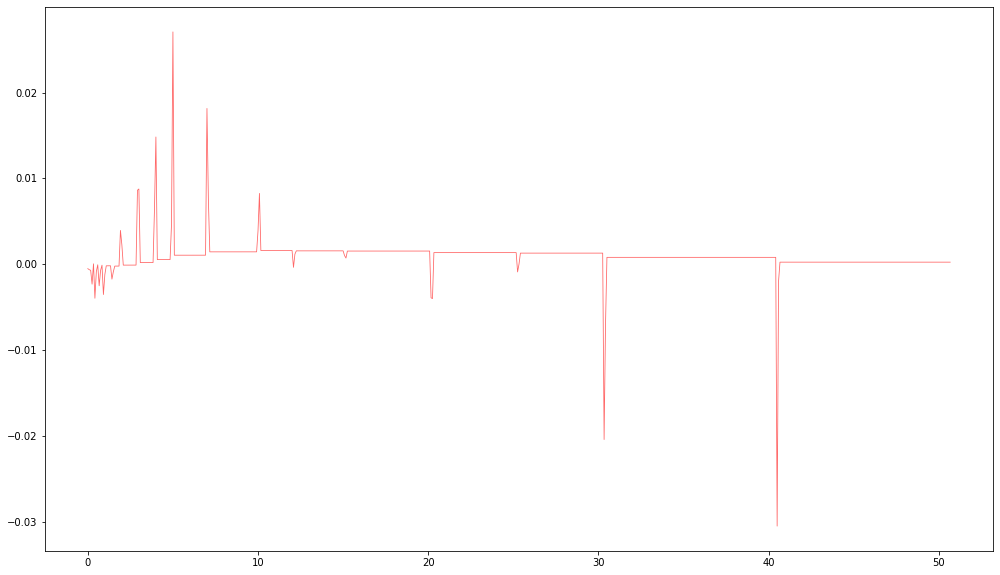

In [16]:
HW.graficar_theta()

Se crean las simulaciones del HullWhite y además se grafican estos.

In [17]:
HW.creacion_simulacion()

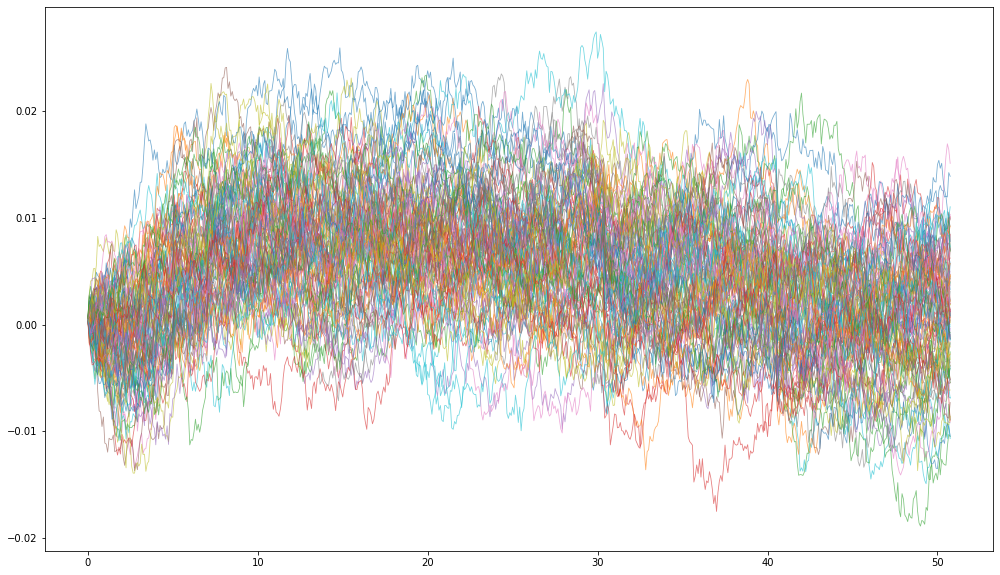

In [18]:
HW.graficar_simulaciones()

Ahora mostramos los percentiles 0 (minimo), 25, 50, 75 y 100 (máximo) de la simulación de HullWhite

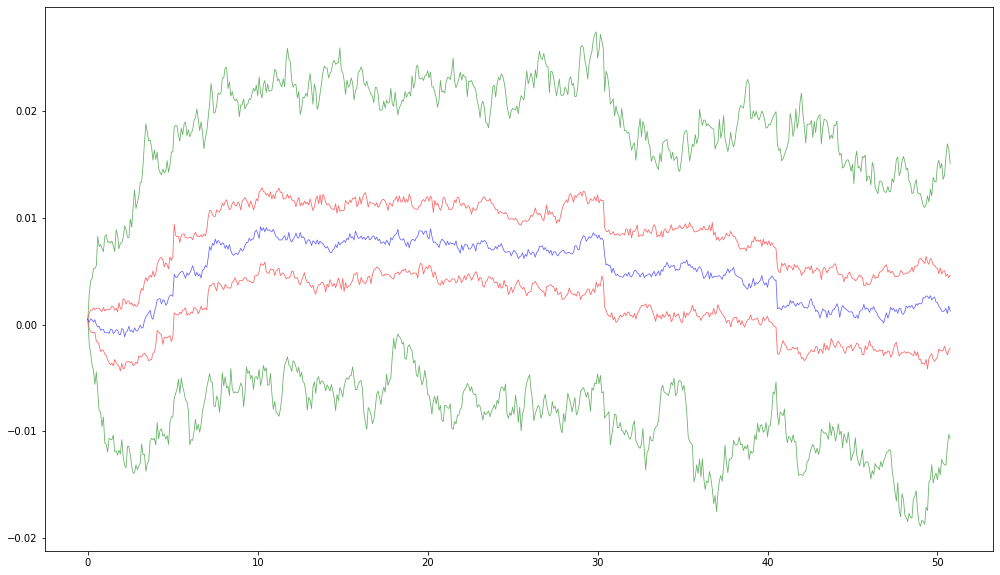

In [19]:
HW.graficar_percentiles_simu()

In [20]:
HW.crear_matriz_A_B()

In [21]:
HW.curva_descuento_media()

Aquí se grafican todas las curvas de descuento asociadas.

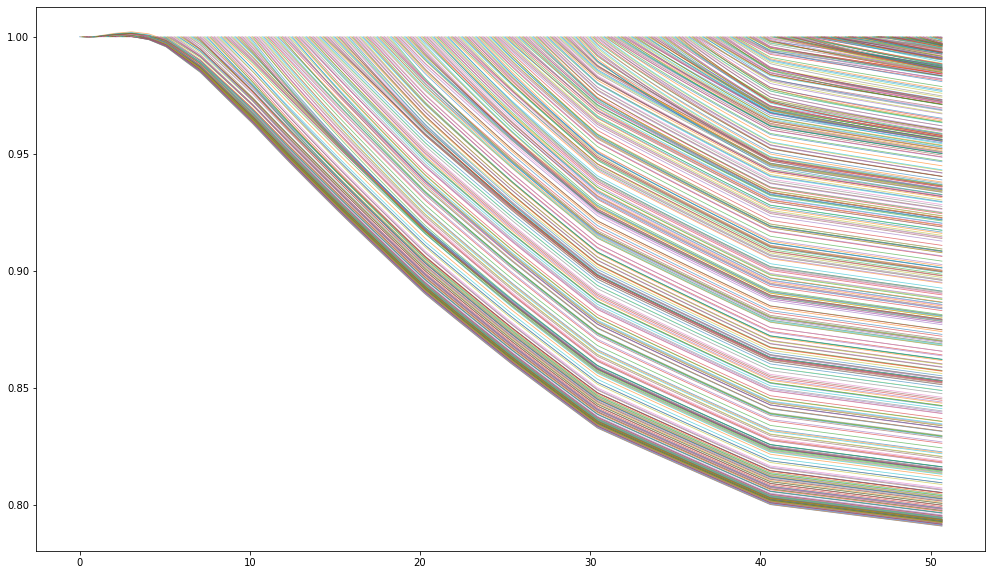

In [22]:
HW.graficar_curvas_descuento_media()

Se calcula la curva de descuentos aproximada y la simulada. Se grafican ambas, en conjunto con la curva dada por itau.

In [23]:
HW.curva_descuentos_aproximada()

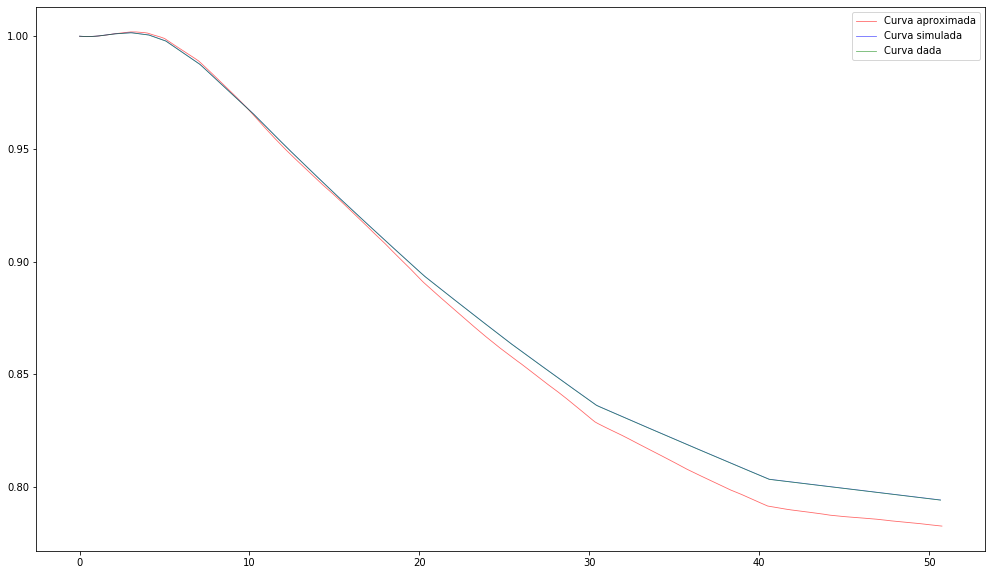

In [24]:
HW.graficar_curvas_descuento_aproximada()

In [25]:
HW.calcular_error()

0.006019676803051198

# Optimización del parametro a

Aquí se realiza la optimización de este parametro.

In [26]:
n_particiones = 20

output = calibrar_HW(a, sigma, curve, r0, nro_simu, n_particiones)

Iteracion:  1
Tiempo:  4.538278579711914
Iteracion:  2
Tiempo:  3.9923408031463623
Iteracion:  3
Tiempo:  4.565399885177612
Iteracion:  4
Tiempo:  4.078187704086304
Iteracion:  5
Tiempo:  4.211304426193237
Iteracion:  6
Tiempo:  4.557037353515625
Iteracion:  7
Tiempo:  3.8746910095214844
Iteracion:  8
Tiempo:  4.448024749755859
Iteracion:  9
Tiempo:  5.585550308227539
Iteracion:  10
Tiempo:  4.743406534194946
Iteracion:  11
Tiempo:  3.8513431549072266
Iteracion:  12
Tiempo:  4.1515562534332275
Iteracion:  13
Tiempo:  3.9436700344085693
Iteracion:  14
Tiempo:  3.8241567611694336
Iteracion:  15
Tiempo:  3.860206127166748
Iteracion:  16
Tiempo:  4.2399420738220215
Iteracion:  17
Tiempo:  4.604830026626587
Iteracion:  18
Tiempo:  3.974668502807617
Iteracion:  19
Tiempo:  4.226137638092041
Iteracion:  20
Tiempo:  3.293276786804199


In [27]:
nuevo_output = calibracion_output(output)

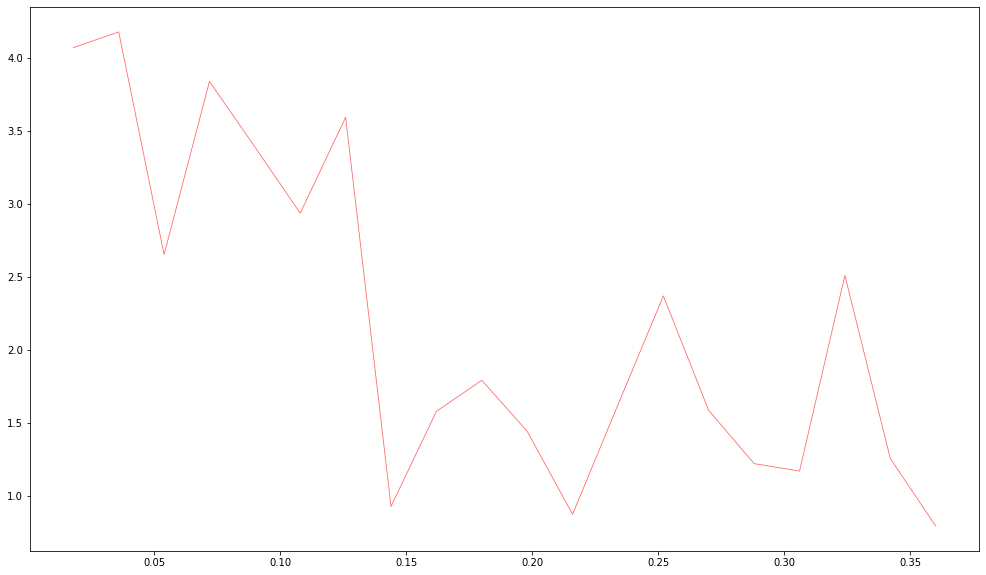

In [28]:
fig, ax = plt.subplots(figsize=(17,10))

ax.plot(nuevo_output[0], nuevo_output[1], lw = 0.8, alpha = 0.6, color = "red")

In [29]:
print("El minimo es: ", min(nuevo_output[1]))

El minimo es:  0.7909032362056139


In [30]:
a_opt = nuevo_output[0][nuevo_output[1].index(min(nuevo_output[1]))]

In [31]:
print("A opt: ", a_opt)

A opt:  0.36000000000000004


# Nueva ejecución

Ahora se ejecuta todo denuevo pero con el parametro a calibrado. Se ejecutan los mismos comandos que antes.

In [32]:
a = a_opt

In [33]:
HW = HullWhite(a, sigma, curve, r0, nro_simu)

In [34]:
HW.creacion_theta()

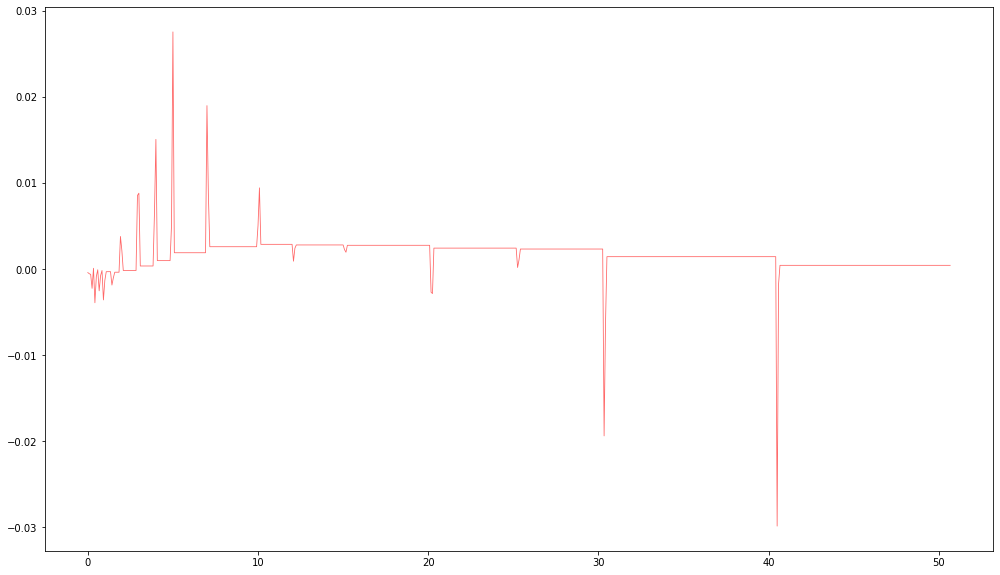

In [35]:
HW.graficar_theta()

In [36]:
HW.creacion_simulacion()

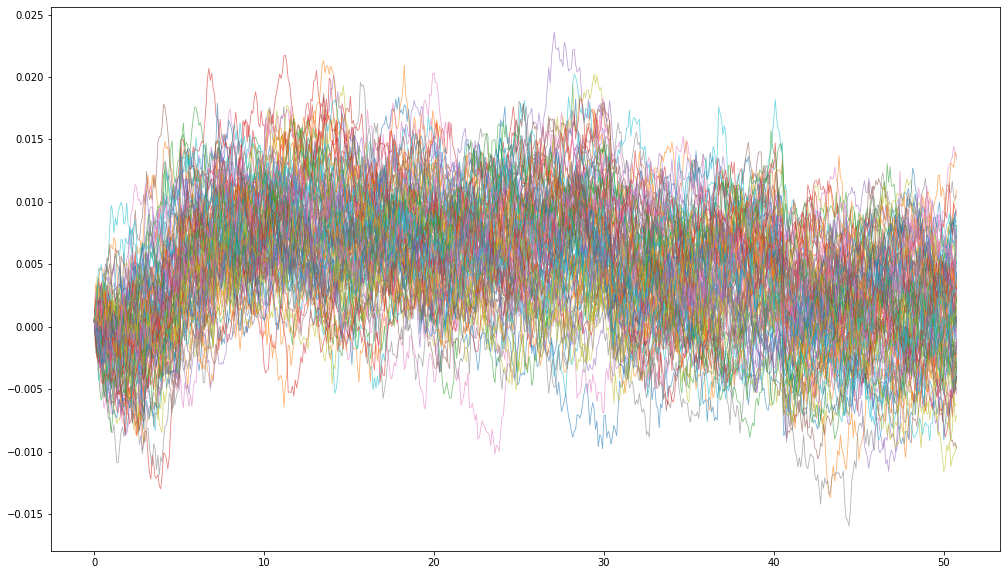

In [37]:
HW.graficar_simulaciones()

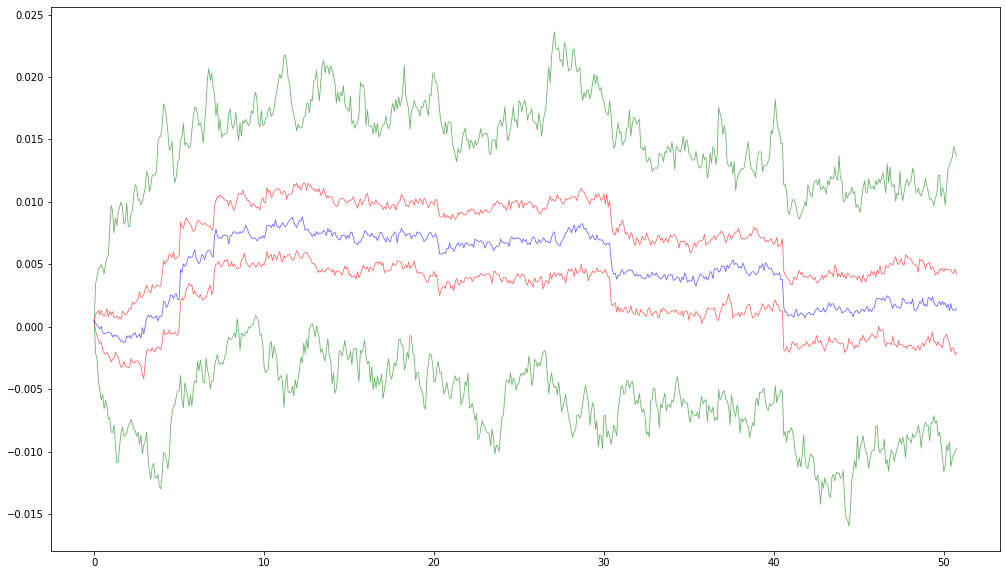

In [38]:
HW.graficar_percentiles_simu()

In [39]:
HW.crear_matriz_A_B()

In [40]:
# Creacion de curvas de descuento

start = time.time()

HW.curvas_descuento()

end = time.time()

print("Tiempo: ", end-start)

Tiempo:  38.79664182662964


In [41]:
HW.curva_descuento_media()

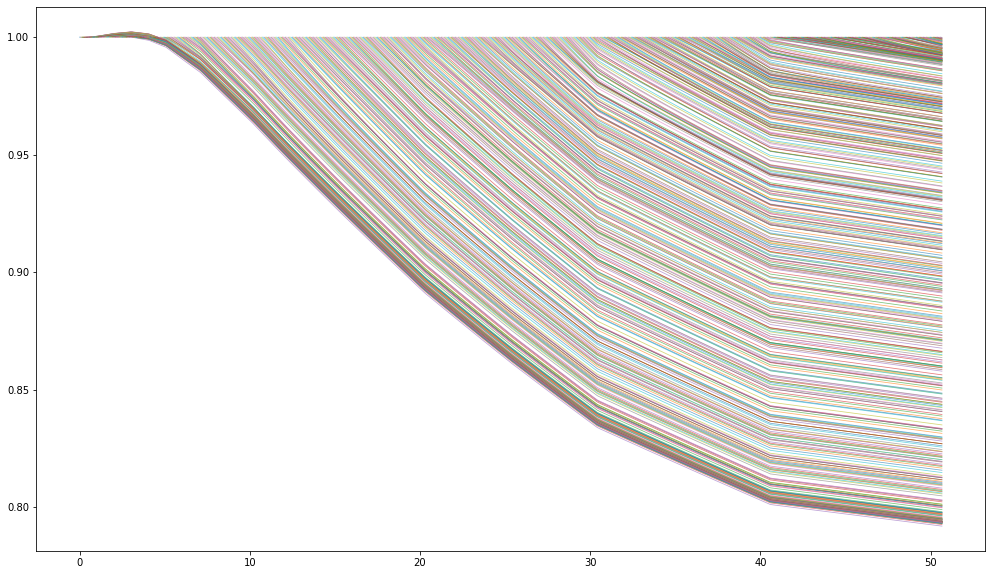

In [42]:
HW.graficar_curvas_descuento_media()

In [43]:
HW.curva_descuentos_aproximada()

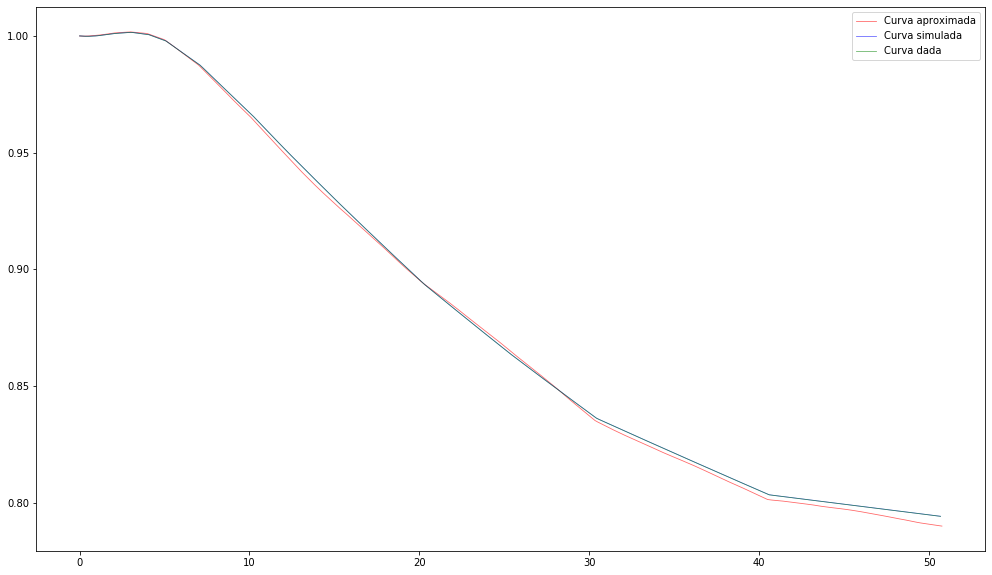

In [44]:
HW.graficar_curvas_descuento_aproximada()

In [45]:
HW.calcular_error()

0.0014693489812053512

In [46]:
# OUTPUT HULLWHITE

# HW.path[numero_simulacion][tiempo_simulado] 
# HW.curvas_descuento_todas[numero_simulacion][t] indica la curva de descuentos asociada a ese t

# INPUT JY

Se ingresan los valores de los parametros de JY estimados. Para el caso de a_n y a_r solo se pone cualquier valor, pues más adelante se calibraran tales parametros. 

In [47]:
# INPUT DE JY

In [48]:
a_n = 10**(-6)
a_r = 10**(-6)
sigma_n = 0.011306
sigma_r = 0.010816
sigma_i = 0.0625627  
corr_n_r = 0.420879649       
corr_r_i = 0.089190964  
corr_i_n = 0.006508171      
n_0 = 0.005
r_0 = 0.005
i_0 = 28000
dt = 0.08333333333333
numero_simulaciones = 100

JY = JYModel(a_n, a_r, sigma_n, sigma_r, sigma_i, corr_n_r, corr_r_i, corr_i_n, curves, 
                 numero_simulaciones, n_0, r_0, i_0)

Se calcula el $\theta_n(t)$ y se grafica.

In [49]:
JY.creacion_theta_n()

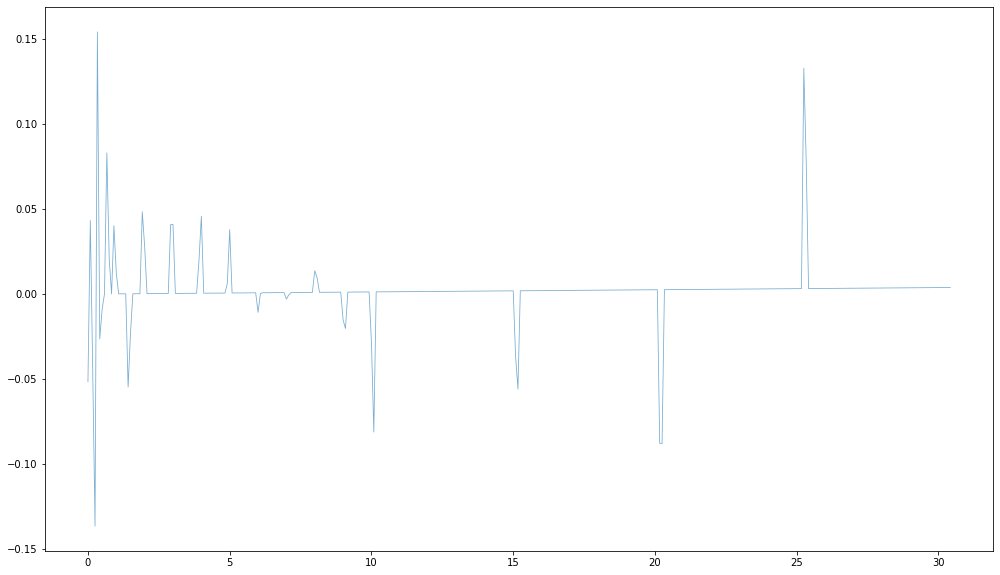

In [50]:
JY.graficar_theta_n()

Se calcula el $\theta_r(t)$ y se grafica.

In [51]:
JY.creacion_theta_r()

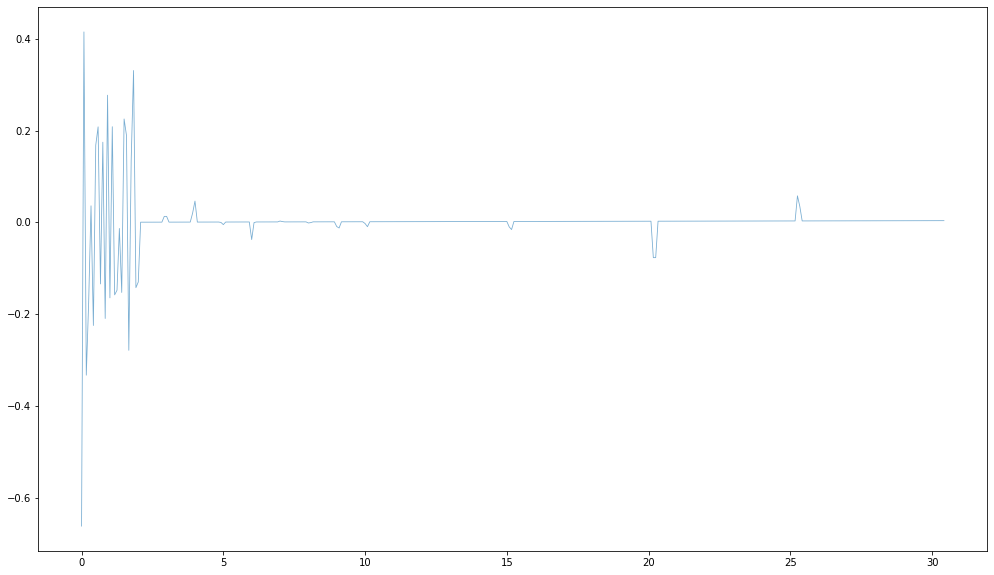

In [52]:
JY.graficar_theta_r()

Se calculan las simulaciones y se calculan las tasas nominales y reales.

In [53]:
JY.calcular_simulaciones()

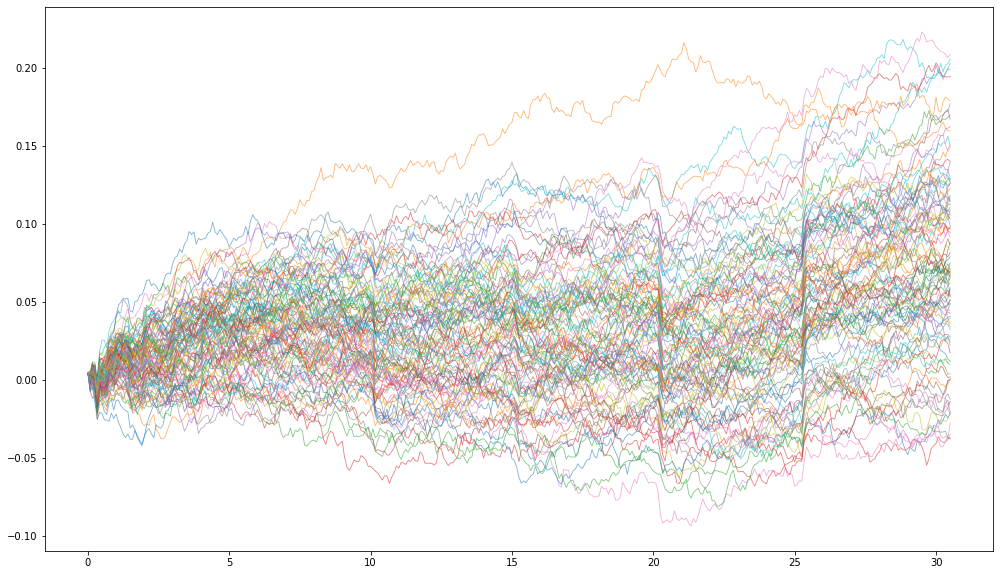

In [54]:
JY.graficar_n()

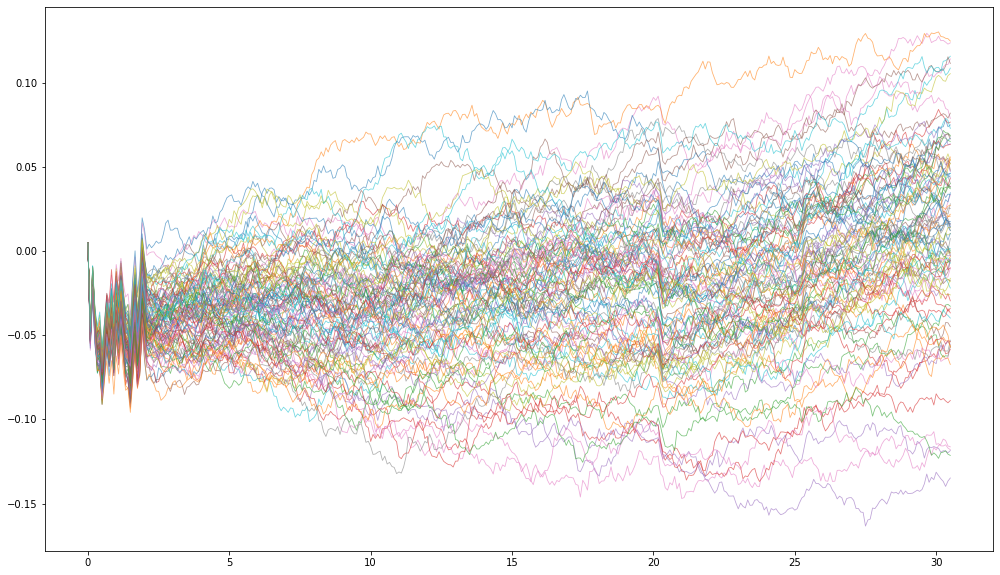

In [55]:
JY.graficar_r()

Ahora se grafica la inflación

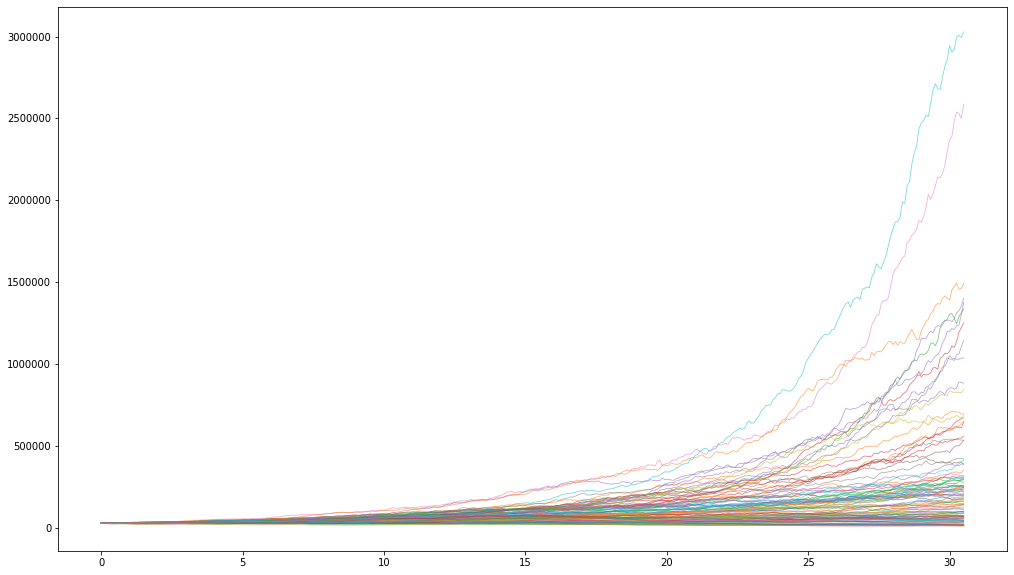

In [56]:
JY.graficar_i()

Ahora se grafican los percentiles 0 (mínimo), 25, 50, 75 y 100 (máximo) asociados a la inflación

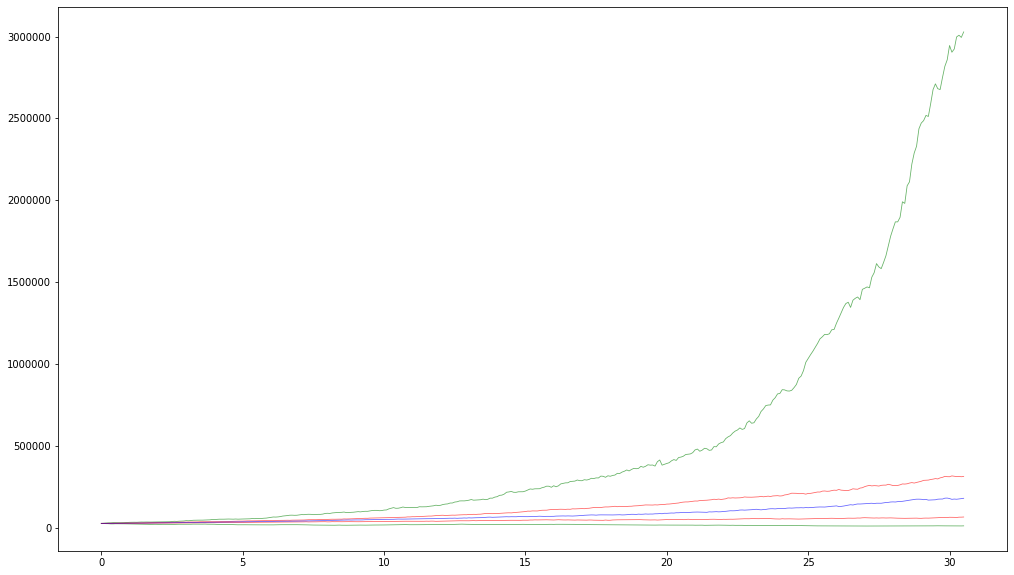

In [57]:
JY.graficar_percentiles_i()

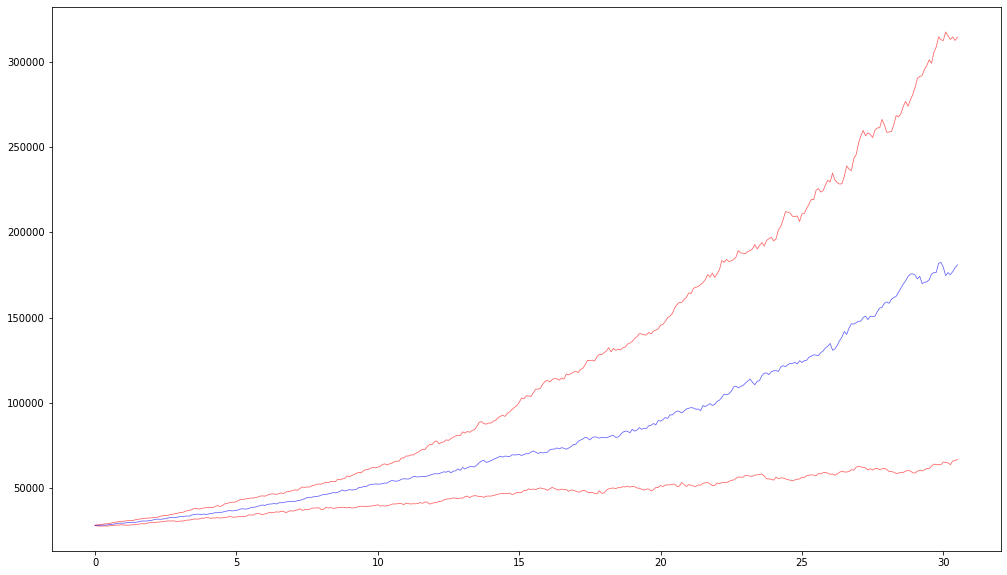

In [58]:
JY.graficar_intervalo_especifico(50)

In [59]:
JY.curva_descuentos_aproximada_n()

In [60]:
JY.curva_descuentos_aproximada_r()

In [61]:
JY.creacion_matriz_A_B_n()

In [62]:
JY.creacion_matriz_A_B_r()

In [63]:
JY.curvas_descuentos_n_r()

In [64]:
JY.calcular_curva_media_n()

In [65]:
JY.curva_descuento_media_n()

Para la curva nominal se calcula la curva simulada y aproximada en conjunto con la curva real (dada). Para calibrar lo que hacemos es minimizar la distancia entre la curva simulada y aproximada.

In [66]:
JY.curva_real_n()

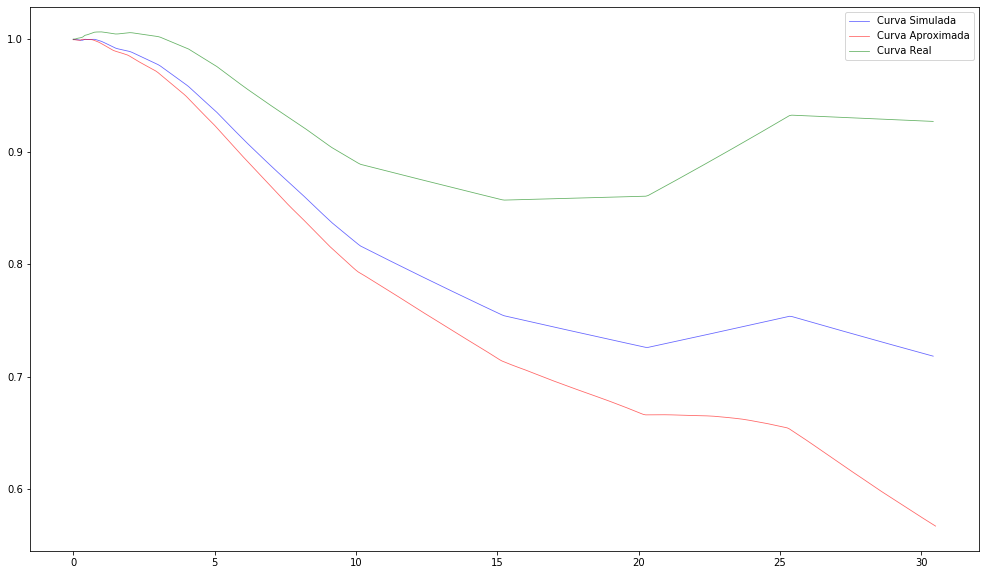

In [67]:
JY.graficar_comparacion_curvas_n()

In [68]:
JY.calcular_curva_media_r()

In [69]:
JY.curva_descuento_media_r()

Para la curva real se calcula la curva simulada y aproximada en conjunto con la curva real (dada). Para calibrar lo que hacemos es minimizar la distancia entre la curva simulada y aproximada.

In [70]:
JY.curva_real_r()

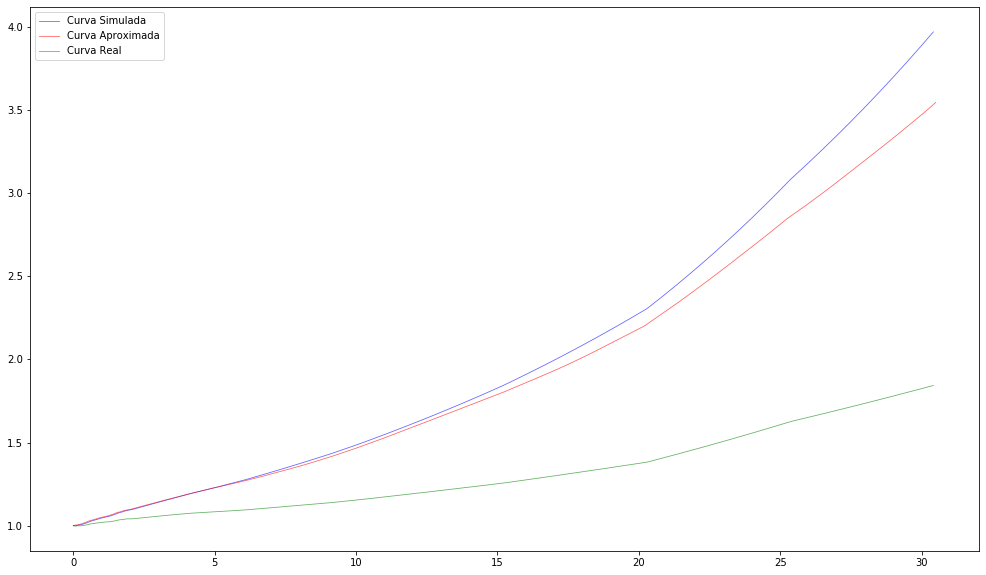

In [71]:
JY.graficar_comparacion_curvas_r()

In [72]:
JY.calcular_error_r()

0.0965994609458925

In [73]:
JY.calcular_error_n()

0.05193812882867051

# Calibración de a_n y a_r

In [74]:
n_particiones = 20

output = calibrar_a_r(0.2, sigma_n, sigma_r, sigma_i, corr_n_r, corr_r_i, corr_i_n, curves, numero_simulaciones,
                 n_0, r_0, i_0, n_particiones)

Iteracion:  1
Tiempo:  19.433517456054688
Iteracion:  2
Tiempo:  21.61091923713684
Iteracion:  3
Tiempo:  20.957732439041138
Iteracion:  4
Tiempo:  19.929879903793335
Iteracion:  5
Tiempo:  23.233384132385254
Iteracion:  6
Tiempo:  21.634273052215576
Iteracion:  7
Tiempo:  21.207668781280518
Iteracion:  8
Tiempo:  20.111112117767334
Iteracion:  9
Tiempo:  21.112732410430908
Iteracion:  10
Tiempo:  30.760582208633423
Iteracion:  11
Tiempo:  22.290948629379272
Iteracion:  12
Tiempo:  30.053493976593018
Iteracion:  13
Tiempo:  22.44882082939148
Iteracion:  14
Tiempo:  21.87112069129944
Iteracion:  15
Tiempo:  21.630293607711792
Iteracion:  16
Tiempo:  21.836822032928467
Iteracion:  17
Tiempo:  22.834145069122314
Iteracion:  18
Tiempo:  20.884902238845825
Iteracion:  19
Tiempo:  18.772781133651733
Iteracion:  20
Tiempo:  20.891884565353394


In [75]:
nuevo_output = calcular_a_r_optimo(output)

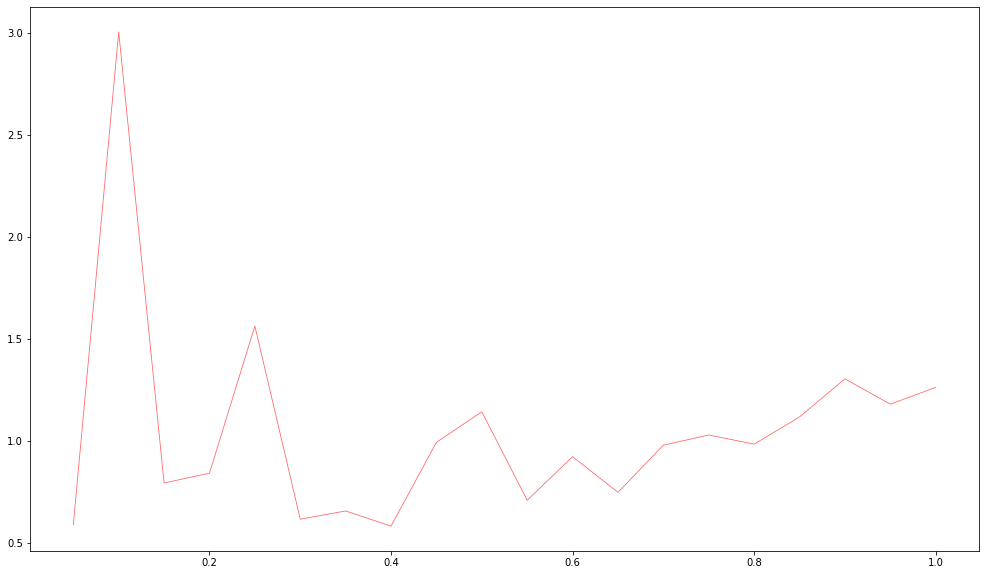

In [76]:
fig, ax = plt.subplots(figsize=(17,10))
ax.plot(nuevo_output[0], nuevo_output[1], lw = 0.8, alpha = 0.6, color = "red")

In [77]:
print("Minimo error: ", min(nuevo_output[1]))

Minimo error:  0.5806285348358268


In [78]:
a_r_optimo = nuevo_output[0][nuevo_output[1].index(min(nuevo_output[1]))]

In [79]:
print("a_r optimo: ", a_r_optimo)

a_r optimo:  0.39999999999999997


In [80]:
n_particiones = 20

output = calibrar_a_n(0.2, sigma_n, sigma_r, sigma_i, corr_n_r, corr_r_i, corr_i_n, curves, numero_simulaciones,
                 n_0, r_0, i_0, n_particiones)

Iteracion:  1
Tiempo:  18.26660680770874
Iteracion:  2
Tiempo:  19.803630352020264
Iteracion:  3
Tiempo:  19.29771113395691
Iteracion:  4
Tiempo:  21.176153659820557
Iteracion:  5
Tiempo:  18.546928644180298
Iteracion:  6
Tiempo:  18.13390326499939
Iteracion:  7
Tiempo:  20.033334732055664
Iteracion:  8
Tiempo:  19.70277500152588
Iteracion:  9
Tiempo:  17.68569302558899
Iteracion:  10
Tiempo:  19.616328954696655
Iteracion:  11
Tiempo:  20.06965923309326
Iteracion:  12
Tiempo:  18.4921977519989
Iteracion:  13
Tiempo:  18.847665071487427
Iteracion:  14
Tiempo:  19.055132150650024
Iteracion:  15
Tiempo:  18.772251844406128
Iteracion:  16
Tiempo:  18.518863677978516
Iteracion:  17
Tiempo:  20.828633308410645
Iteracion:  18
Tiempo:  18.912603616714478
Iteracion:  19
Tiempo:  18.63738512992859
Iteracion:  20
Tiempo:  19.010096549987793


In [81]:
nuevo_output = calcular_a_n_optimo(output)

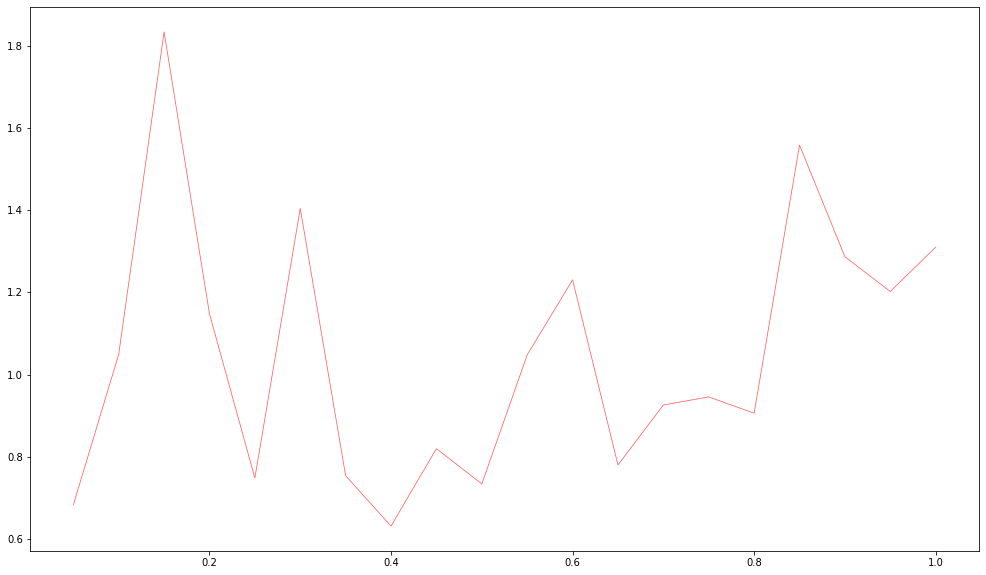

In [82]:
fig, ax = plt.subplots(figsize=(17,10))
ax.plot(nuevo_output[0], nuevo_output[1], lw = 0.8, alpha = 0.6, color = "red")

In [83]:
print("Minimo error: ", min(nuevo_output[1]))

Minimo error:  0.6317902226179564


In [84]:
a_n_optimo = nuevo_output[0][nuevo_output[1].index(min(nuevo_output[1]))]

In [85]:
print("a_n optimo: ", a_n_optimo)

a_n optimo:  0.39999999999999997


# Ejecución nuevamente

Se ejecuta nuevamente el JY con los parametros calibrados. Se ejecutan los mismos comandos que antes.

In [86]:
JY = JYModel(a_n_optimo, a_r_optimo, sigma_n, sigma_r, sigma_i, corr_n_r, corr_r_i, corr_i_n, curves, 
                 numero_simulaciones, n_0, r_0, i_0)

In [87]:
JY.creacion_theta_n()

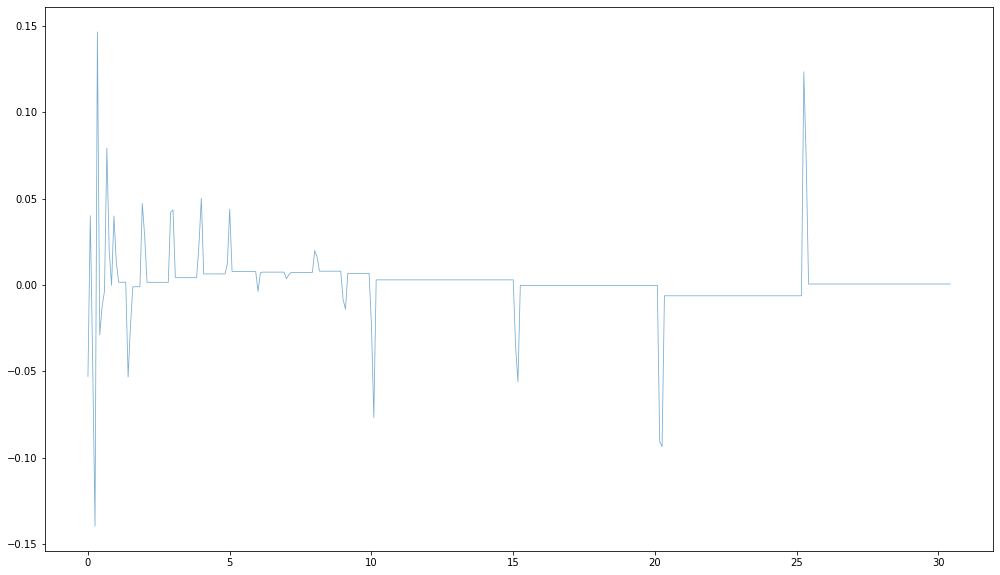

In [88]:
JY.graficar_theta_n()

In [89]:
JY.creacion_theta_r()

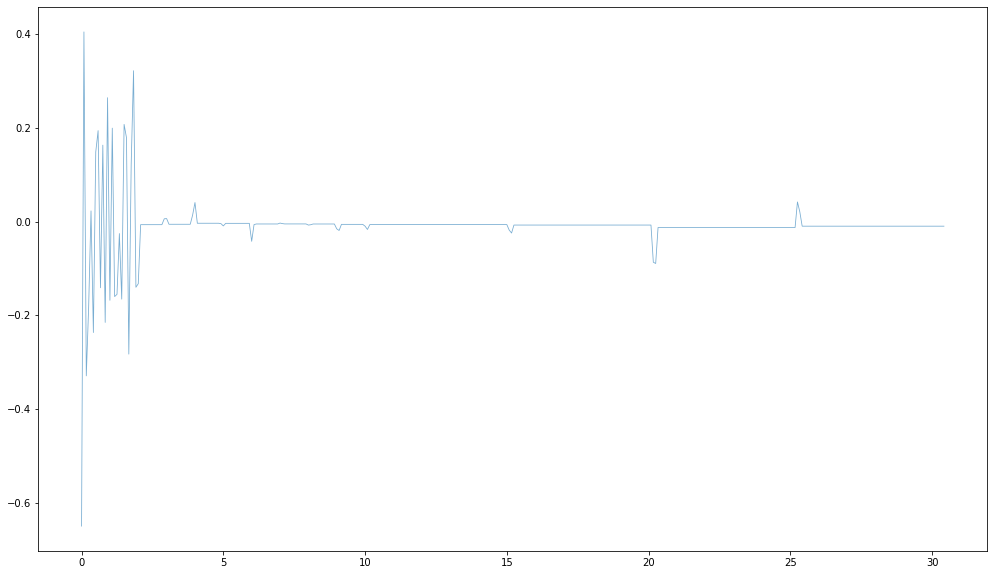

In [90]:
JY.graficar_theta_r()

In [91]:
JY.calcular_simulaciones()

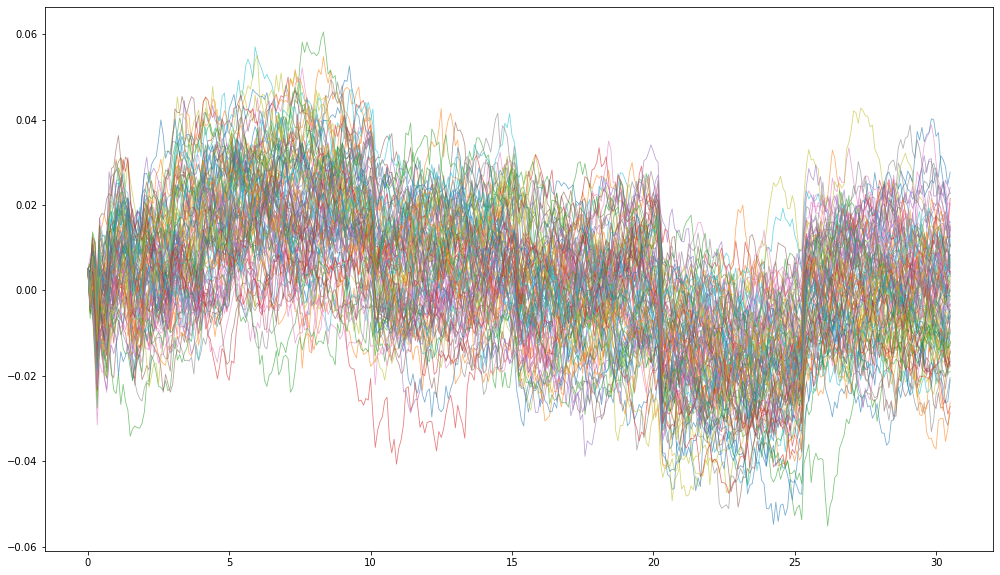

In [92]:
JY.graficar_n()

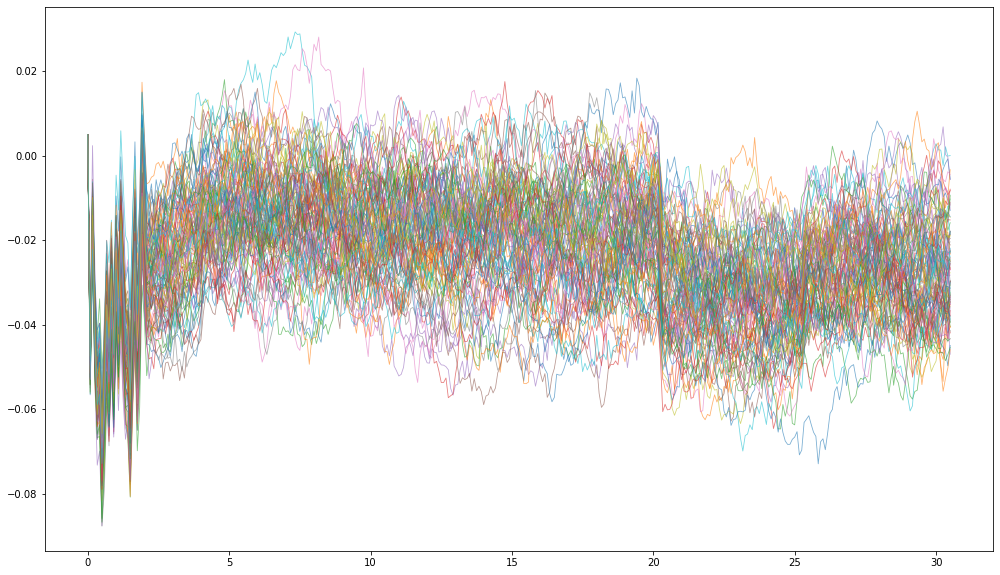

In [93]:
JY.graficar_r()

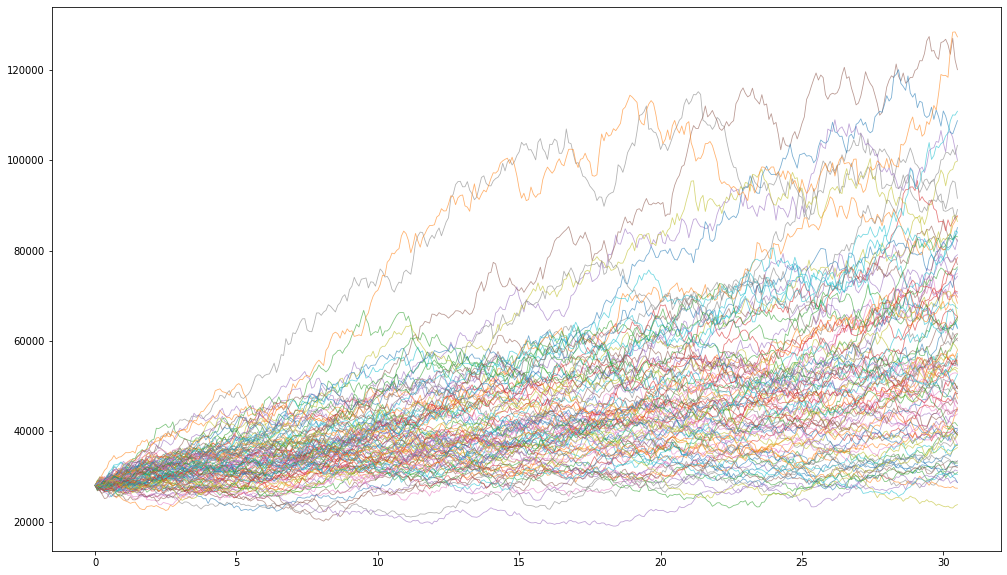

In [94]:
JY.graficar_i()

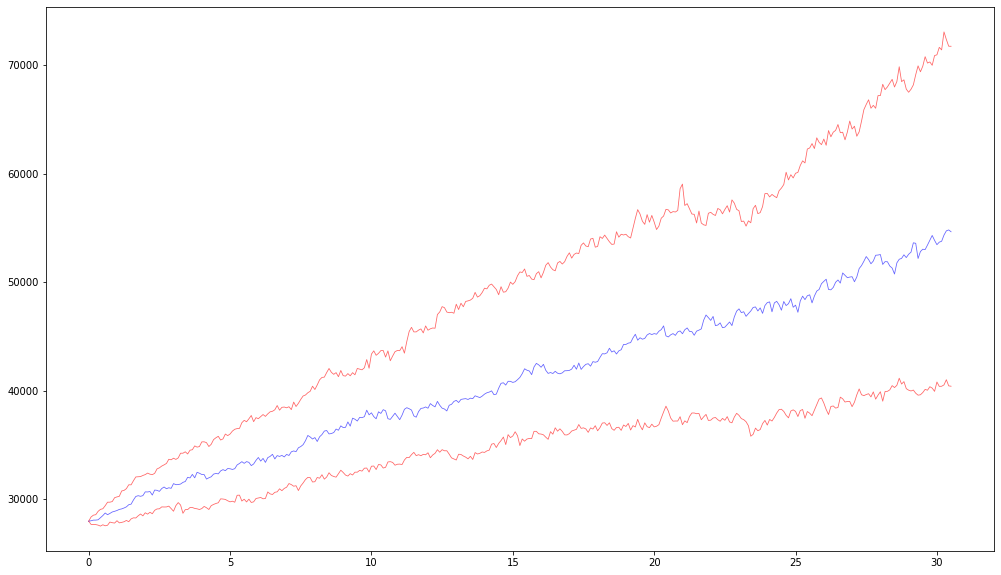

In [95]:
JY.graficar_intervalo_especifico(50)

In [96]:
JY.curva_descuentos_aproximada_n()

In [97]:
JY.curva_descuentos_aproximada_r()

In [98]:
JY.creacion_matriz_A_B_n()

In [99]:
JY.creacion_matriz_A_B_r()

In [100]:
JY.curvas_descuentos_n_r()

In [101]:
JY.calcular_curva_media_n()

In [102]:
JY.curva_descuento_media_n()

In [103]:
JY.curva_real_n()

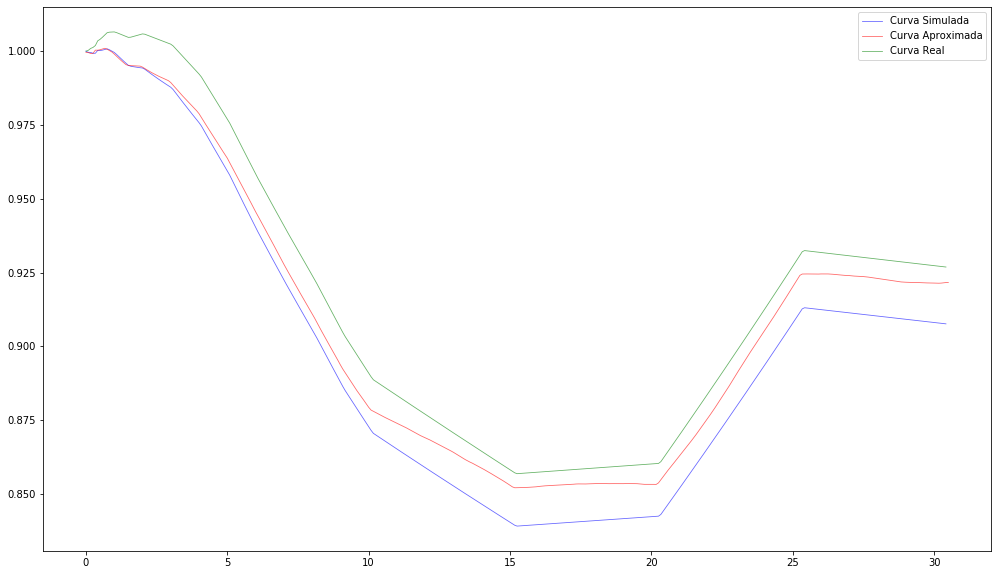

In [104]:
JY.graficar_comparacion_curvas_n()

In [105]:
JY.calcular_curva_media_r()

In [106]:
JY.curva_descuento_media_r()

In [107]:
JY.curva_real_r()

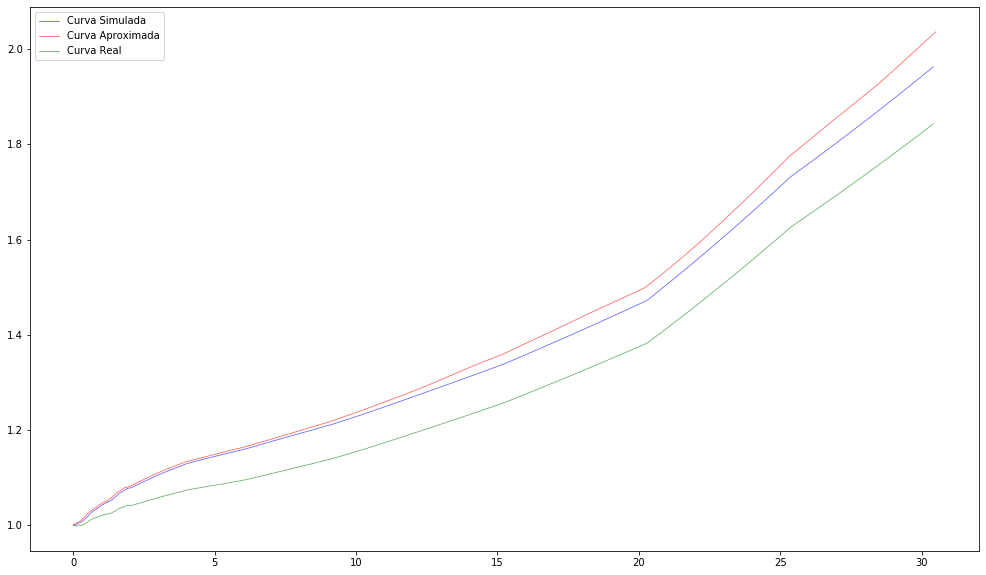

In [108]:
JY.graficar_comparacion_curvas_r()

In [109]:
JY.calcular_error_r()

0.023849755222776173

In [110]:
JY.calcular_error_n()

0.008965457208256249

In [111]:
# OUTPUT JY


# JY.r_total[numero_simulacion][tiempo_simulado]
# JY.n_total[numero_simulacion][tiempo_simulado]
# JY.i_total[numero_simulacion][tiempo_simulado]

# JY.curvas_descuento_n[numero_simulacion][t] indica la curva de descuentos asociada a ese t
# JY.curvas_descuento_r[numero_simulacion][t] indica la curva de descuentos asociada a ese t

In [112]:
tiempo_final_todo = time.time()

In [113]:
print("El tiempo total demorado es: ", tiempo_final_todo - tiempo_inicial_todo)

El tiempo total demorado es:  1065.6280403137207
